# Example SciDB queries for trade and quote data

This iPython Notebook replicates the work done by AFL queries at [this repo's main page](https://github.com/Paradigm4/TAQ/) in SciDB-py. 

The example queries here use the following example data obtained from Nyxdata:


In [1]:
!wget ftp://ftp.nyxdata.com/Historical%20Data%20Samples/Daily%20TAQ/EQY_US_ALL_TRADE_20131218.zip \
    --directory-prefix=/tmp   
    

--2016-04-04 02:38:23--  ftp://ftp.nyxdata.com/Historical%20Data%20Samples/Daily%20TAQ/EQY_US_ALL_NBBO_20131218.zip
           => ‘/tmp/EQY_US_ALL_NBBO_20131218.zip.2’
Resolving ftp.nyxdata.com (ftp.nyxdata.com)... 159.125.78.28
Connecting to ftp.nyxdata.com (ftp.nyxdata.com)|159.125.78.28|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /Historical Data Samples/Daily TAQ ... done.
==> SIZE EQY_US_ALL_NBBO_20131218.zip ... 2113968509
==> PASV ... done.    ==> RETR EQY_US_ALL_NBBO_20131218.zip ... done.
Length: 2113968509 (2.0G) (unauthoritative)

100%[====================================>] 2,113,968,509 3.35MB/s   in 10m 18s

2016-04-04 02:48:41 (3.26 MB/s) - ‘/tmp/EQY_US_ALL_NBBO_20131218.zip.2’ saved [2113968509]



In [2]:
!wget ftp://ftp.nyxdata.com/Historical%20Data%20Samples/Daily%20TAQ/EQY_US_ALL_NBBO_20131218.zip \
    --directory-prefix=/tmp   

--2016-04-04 02:48:41--  ftp://ftp.nyxdata.com/Historical%20Data%20Samples/Daily%20TAQ/EQY_US_ALL_TRADE_20131218.zip
           => ‘/tmp/EQY_US_ALL_TRADE_20131218.zip’
Resolving ftp.nyxdata.com (ftp.nyxdata.com)... 159.125.78.28
Connecting to ftp.nyxdata.com (ftp.nyxdata.com)|159.125.78.28|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /Historical Data Samples/Daily TAQ ... done.
==> SIZE EQY_US_ALL_TRADE_20131218.zip ... 312753367
==> PASV ... done.    ==> RETR EQY_US_ALL_TRADE_20131218.zip ... done.
Length: 312753367 (298M) (unauthoritative)

100%[======================================>] 312,753,367 4.05MB/s   in 76s    

2016-04-04 02:49:57 (3.93 MB/s) - ‘/tmp/EQY_US_ALL_TRADE_20131218.zip’ saved [312753367]



The example data file format specification is available from: http://www.nyxdata.com/doc/224904

## Loading the data into ScIDB

The `trades_load.sh` and `trades_redim.sh` scripts load the `EQY_US_ALL_TRADE_20131218.zip` data and redimension them into a `ms` (time) by `symbol_index` 2-d SciDB array. The script also creates an auxiliary mapping array named `tkr` between string ticker symbol and integer symbol index.

The `quotes_load.sh` and `quotes_redim.sh` script does the same thing but for the `EQY_US_ALL_NBBO` quote data file.

Run the following to load and redimension the example data

In [52]:
import subprocess
subprocess.call(["./trades_load.sh"])
#subprocess.call(["./trades_load.sh", "/tmp/EQY_US_ALL_TRADES_20131218.zip", "500000"])
subprocess.call("./trades_redim.sh")

0

In [53]:
subprocess.call(["./quotes_load.sh", "/tmp/EQY_US_ALL_NBBO_20131218.zip",  "1000000"])
subprocess.call("./quotes_redim.sh")

0

## Connecting to the database

Then let's run some queries on the loaded trades and quote (TAQ) data from the comfort of SciDB-Py.
First let us set up the connectivity to the database (and also import some useful libraries)

In [54]:
import matplotlib.pyplot as plt
from scidbpy import connect
import time
sdb = connect("http://localhost:8080")
afl = sdb.afl

Next, associate Python objects with SciDB arrays (no data transfers yet -- just connections)

In [55]:
trades = sdb.wrap_array('trades')
quotes = sdb.wrap_array('quotes')
tkr = sdb.wrap_array('tkr')

An example lookup

In [56]:
if subprocess.call(["iquery", "-aq", "load_library('limit')"]) == 0:
    print('loaded library: limit')
else:
    print('''requires user to install the `limit` library. 
            See https://github.com/Paradigm4/limit. 
            Otherwise, use the slower version: tkr.todataframe().head()''')
tkr.limit(5).todataframe() 

loaded library: limit


,symbol
symbol_index,
0,A
1,AA
2,AA PR
3,AADR
4,AAIT


## Looking up trades by symbol string

Join with the auxiliary `tkr` array to look up data by ticker symbol name. Here are examples that count the number of trades and quotes for 'BAM'.


In [57]:
symbol = "ABBV"
print("%d trades for %s " % (sdb.merge(trades,
            tkr.filter("symbol='%s'" % symbol)
          ).nonempty(), symbol))
print("%d quotes for %s " % (sdb.merge(quotes,
            tkr.filter("symbol='%s'" % symbol)
          ).nonempty(), symbol))

37932 trades for ABBV 
59718 quotes for ABBV 


As expected we see more quotes than trades for this instrument. Note that you can also just filter directly by symbol index using `between` if you know it. For example:

In [58]:
[sdb.merge(trades,
            tkr.filter("symbol='%s'" % symbol)
          ).nonempty(), symbol]

[37932, 'ABBV']

In [59]:
tkr.filter("symbol='%s'" % symbol).todataframe()

,symbol
symbol_index,
22,ABBV


In [61]:
print(trades.dim_names)
trades.between(22, 'null', 22, 'null').nonempty()

[u'symbol_index', u'tm']


37932

# Computing VWAP

Let's turn to another common kind of operation, computing volume-weighted average price (VWAP). We'll compute it for every instrument across their raw trade data in the array tades, and store the result into a new array called 'VWAP'.

In [62]:
vwap = trades.apply('pv', 'price*volume')
vwap = sdb.afl.cumulate(vwap, \
                        'sum(pv) as numerator', \
                        'sum(volume) as denominator', 'tm')
vwap = vwap.apply('vwap', 'numerator/denominator')
sdb.merge(vwap, tkr[tkr == 'AAPL']).\
    limit(5).\
    todataframe()

numerator  denominator        vwap symbol
symbol_index tm                                                 
13           14781433     2780.0            5  556.000000   AAPL
             14833032    58375.0          105  555.952381   AAPL
             15477542   169209.0          305  554.783607   AAPL
             15643058   224698.0          405  554.809877   AAPL
             15689610   502008.0          905  554.704972   AAPL

In [63]:
if subprocess.call(["iquery", "-aq", "load_library('axial_aggregate')"]) !=0: 
    print('The library is only available to Enterprise customers. Contact Paradigm4 for more details. ')

In [64]:
sdb.merge(trades, tkr[tkr == 'AAPL']).\
    limit(5).\
    todataframe()

price  volume  sequence_number condition exchange  \
symbol_index tm                                                             
13           14781433  556.00       5              906      @ TI        Q   
             14833032  555.95     100              907       @FT        Q   
             15477542  554.17     200              909       @FT        P   
             15643058  554.89     100              910       @FT        Q   
             15689610  554.62     500              911         T        P   

                      symbol  
symbol_index tm               
13           14781433   AAPL  
             14833032   AAPL  
             15477542   AAPL  
             15643058   AAPL  
             15689610   AAPL

In [65]:
minute_bars = trades.apply('timeprice', 'tuple(tm,price)')
minute_bars = sdb.afl.regrid(minute_bars, 1, 60000,
            'axial_first(timeprice) as open',
            'max(price) as high',
            'min(price) as low',
            'axial_last(timeprice) as close'
          )
minute_bars = minute_bars.eval()

sdb.merge(minute_bars, tkr[tkr == 'AAPL']).\
    limit(20).\
    todataframe().tail()

open    high     low   close symbol
symbol_index tm                                        
13           298  552.99  552.99  552.99  552.99   AAPL
             312  552.90  552.90  552.90  552.90   AAPL
             329  552.98  553.02  552.98  553.02   AAPL
             335  553.29  553.29  553.05  553.05   AAPL
             352  553.35  553.35  553.21  553.21   AAPL

In [66]:
minute_bars.limit(20).todataframe().tail()

open   high     low  close
symbol_index tm                              
0            585  56.99  57.02  56.875  56.93
             586  56.93  56.99  56.900  56.98
             587  56.99  57.03  56.960  57.00
             588  57.00  57.01  56.980  56.99
             589  56.95  57.00  56.925  56.98

Let's pull out one of these minute bar time series for a particuar stock, CVS. We can consult the symbols array to find it's index directly.

In [67]:
symbol = 'AAN'
tkr[tkr == symbol].todataframe()

,symbol
symbol_index,
9,AAN


So this says that symbol index 1612 corresponds to CVS.

We can use SciDB's cross_join to avoid an explicit index lookup. We do need to use a repart to bring the symbols array schema into a conformable chunking scheme with the minute_bars array. Only the first 10 minutes of bars are shown below:

In [68]:
mb1 = sdb.merge(minute_bars, 
                tkr[tkr == symbol]).todataframe()
mb1.head()

open   high    low   close symbol
symbol_index tm                                     
9            570  28.89  28.97  28.73  28.730    AAN
             571  28.96  28.96  28.87  28.870    AAN
             572  28.80  28.84  28.73  28.815    AAN
             573  28.80  28.80  28.80  28.800    AAN
             574  28.83  28.83  28.73  28.730    AAN

Note! That 570 minutes = 9:30 AM.

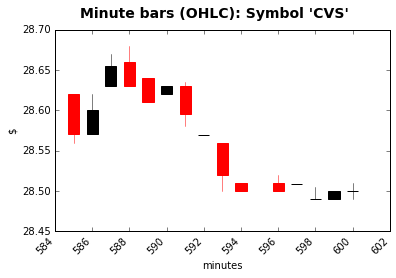

In [69]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.finance import candlestick_ohlc

# Split the dimensions to get the minute co-ordinates
l1, l2 = zip(*mb1.index.get_values())
# unify into a nparray of tuples for use in candlestick graph
q2 = zip(l2, mb1.open, mb1.high, mb1.low, mb1.close)

fig, ax = plt.subplots()
fig.subplots_adjust(bottom=0.2)
fig.suptitle('Minute bars (OHLC): Symbol \'AAN\' ', fontsize=14, fontweight='bold')
ax.set_xlabel('minutes')
ax.set_ylabel('$')

candlestick_ohlc(ax, q2[15:30], width=0.6)

ax.autoscale_view()
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')

plt.show()

## AsOf join

The `asof` operator joins trade data with quote data. At time points where quote data is not available, the last known value is looked up and filled in. This is sometimes also called a 'last value carry forward' join or 'piecewise constant interpolation join'.

The syntax is:
```
asof(A, B [, aggrDim [, missingCode]])
```

where the inputs are:
- `A & B`: two arrays that have the same dimensionality;
- `aggrDim`: the dimension in A along which to find last_value. Default is the last dimension.
- `missingCode`: the missing code to use, when an A record cannot be found. Default is 0.

Here is an example that joins trades and quotes for **'BAM'**. We use the fact that we know the symbol index for **BAM** is **615** from the last example. In this example, we only choose the values with dummy dimension of **0** (see comments below).

In [71]:
symbol = 'AAN'
tkr[tkr == symbol].todataframe()

,symbol
symbol_index,
9,AAN


Next run some counts for the data for this symbol

In [73]:
print('Dimensions of trades and quotes arrays:')
print(trades.dim_names)
print('\n# of quotes for symbol = %s' % symbol)
q1 = quotes.between(9, 'null', 9, 'null')
print(q1.nonempty())
print('\n# of trades for symbol = %s' % symbol)
t1 = trades.between(9, 'null', 9, 'null')
print(t1.nonempty())


Dimensions of trades and quotes arrays:
[u'symbol_index', u'tm']

# of quotes for symbol = AAN
14443

# of trades for symbol = AAN
4488


Now note that the dimensions of the `quotes` and `trades` arrays did not have identical chunking in the first place. 

In [74]:
from re import search
print(search('\[.*\]', q1.schema).group(0))
print(search('\[.*\]', t1.schema).group(0))

[symbol_index=0:*,10,0,tm=0:86399999,86400000,0]
[symbol_index=0:*,10,0,tm=0:86399999,86400000,0]


We resolve this by `redimension`-ing the (smaller) trades subarray for selected symbol to the same dimension schema as the `quotes` subarray

In [15]:
t2 = t1.redimension("<price:double NULL DEFAULT null,volume:int64 NULL DEFAULT null,\
                    sequence_number:int64 NULL DEFAULT null,condition:string NULL DEFAULT null,\
                    exchange:string NULL DEFAULT null> \
                    [dummy=0:999,1000,0,symbol_index=0:*,10,0,ms=0:86399999,86400000,0]")

Next we run the `asof` join and make some simple checks:

In [75]:
asof1 = quotes.asof(trades)
asof1 = asof1.eval()

In [76]:
print('\n# of elements in the joined result:')
print(asof1.nonempty())
print('\nThe head() of the joined array')
sdb.merge(asof1.project('ask_price', 'ask_size', 'bid_price', 'bid_size', 'price', 'volume'), tkr[tkr == 'AAN']).\
    limit(20).\
    todataframe().tail()

ask_price  ask_size  bid_price  bid_size   price  \
symbol_index tm                                                           
9            34261583      28.97         1      28.89         3  28.900   
             34275208      28.96         4      28.77         1  28.900   
             34279138      28.99         1      28.91         3  28.910   
             34281947      28.94         1      28.85         2  28.910   
             34299156      28.91         1      28.88         2  28.895   

                       volume symbol  
symbol_index tm                       
9            34261583     100    AAN  
             34275208    1000    AAN  
             34279138     100    AAN  
             34281947     200    AAN  
             34299156     300    AAN

# RegNMS (Compliance)

In [78]:
sdb.merge(asof1.filter('ask_price < bid_price').project('ask_price', 'ask_size', 'bid_price', 'bid_size', 'price', 'volume'), tkr[tkr=='AAN']).\
    limit(5).\
    todataframe()

ask_price  ask_size  bid_price  bid_size   price  \
symbol_index tm                                                           
9            50542379        0.0         0      28.42         2  28.435   
             50543934        0.0         0      28.42         2  28.435   
             50548052        0.0         0      28.42         2  28.435   
             50564525        0.0         0      28.41         1  28.410   
             51689655        0.0         0      28.48         3  28.480   

                       volume symbol  
symbol_index tm                       
9            50542379     100    AAN  
             50543934     100    AAN  
             50548052     300    AAN  
             50564525     100    AAN  
             51689655     300    AAN